In [1]:
import pickle
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# 检查 MPS 是否可用
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS device found!")
else:
    print("MPS device not found.")
    mps_device = torch.device("cpu")

MPS device found!


In [3]:
dataset_path = "bios_train.pkl"  
with open(dataset_path, 'rb') as f:
    bios_data = pickle.load(f)

# Convert data into pandas dataframe
if isinstance(bios_data, list):
    bios_df = pd.DataFrame(bios_data)
else:
    bios_df = bios_data

/var/folders/jj/84v_jpsx4rj3__y62xh3klxm0000gn/T/ipykernel_61533/1766486254.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  bios_data = pickle.load(f)


In [4]:
# Extract profession words from BIB dataset classification labels
# https://huggingface.co/datasets/LabHC/bias_in_bios

profession_list_from_readme = [ 
    "accountant", "architect", "attorney", "chiropractor", "comedian", "composer", "dentist", "dietitian", "dj",
    "filmmaker", "interior_designer", "journalist", "model", "nurse", "painter", "nurse", "paralegal", "pastor", "personal_trainer",
    "photographer", "physician", "poet", "professor", "psychologist", "rapper", "software_engineer", "surgeon", "teacher",
    "yoga_teacher" 
]
gender_terms = ["he", "she", "man", "woman", "person", "individual", "male", "female"] 


In [5]:
# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Move model to the appropriate device
model = model.to(mps_device)

In [6]:
# Define function to get word embeddings, using average word vectors from GPT-2
def get_word_embedding(word, tokenizer, model, device):
    
    inputs = tokenizer(word, return_tensors="pt").to(device)
    outputs = model(**inputs)
    # 使用最后隐藏层的第一个 token 的隐藏状态作为词嵌入 (可以尝试其他 pooling 策略)
    word_embedding = outputs.last_hidden_state[:, 0, :].mean(dim=0) # 使用 mean pooling
    return word_embedding.detach().cpu().numpy() # 移动到 CPU 并转换为 numpy 数组


In [7]:
# Obtain word embeddings for occupational and gender vocabulary
profession_embeddings = {
    profession: get_word_embedding(profession, tokenizer, model, mps_device)
    for profession in profession_list_from_readme
}
gender_embeddings = {
    gender: get_word_embedding(gender, tokenizer, model, mps_device)
    for gender in gender_terms
}

In [8]:
# Calculating cosine similarity between vocational and gender terms
print("\nCosine Similarity between Professions and Gender Terms:")
similarity_scores = {}
for profession, profession_emb in profession_embeddings.items():
    similarity_scores[profession] = {}
    print(f"\nProfession: {profession}")
    for gender_term, gender_emb in gender_embeddings.items():
        similarity = cosine_similarity(np.array([profession_emb]), np.array([gender_emb]))[0][0]
        similarity_scores[profession][gender_term] = similarity
        print(f"  Cosine Similarity with '{gender_term}': {similarity:.4f}")



Cosine Similarity between Professions and Gender Terms:

Profession: accountant
  Cosine Similarity with 'he': 0.9929
  Cosine Similarity with 'she': 0.9925
  Cosine Similarity with 'man': 0.9904
  Cosine Similarity with 'woman': 0.9859
  Cosine Similarity with 'person': 0.9917
  Cosine Similarity with 'individual': 0.9951
  Cosine Similarity with 'male': 0.9925
  Cosine Similarity with 'female': 0.9874

Profession: architect
  Cosine Similarity with 'he': 0.9969
  Cosine Similarity with 'she': 0.9942
  Cosine Similarity with 'man': 0.9934
  Cosine Similarity with 'woman': 0.9851
  Cosine Similarity with 'person': 0.9930
  Cosine Similarity with 'individual': 0.9916
  Cosine Similarity with 'male': 0.9927
  Cosine Similarity with 'female': 0.9886

Profession: attorney
  Cosine Similarity with 'he': 0.9955
  Cosine Similarity with 'she': 0.9935
  Cosine Similarity with 'man': 0.9906
  Cosine Similarity with 'woman': 0.9824
  Cosine Similarity with 'person': 0.9897
  Cosine Similarity w

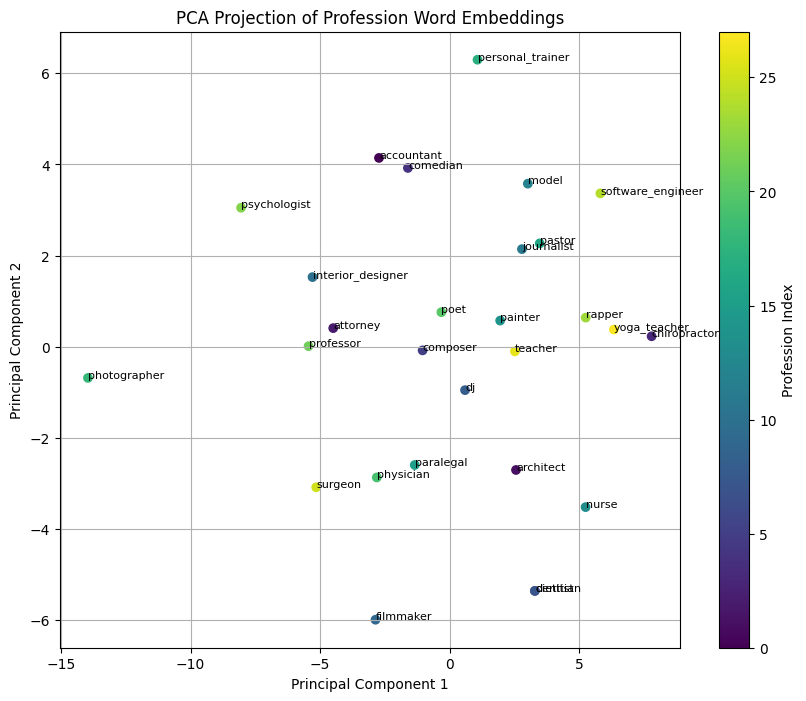

In [9]:
# PCA downscaling to 2D and visualization 
profession_names = list(profession_embeddings.keys())
embeddings_for_pca = np.array([profession_embeddings[name] for name in profession_names])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_for_pca)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=range(len(profession_names)), cmap='viridis') # 使用颜色区分不同职业
for i, profession in enumerate(profession_names):
    plt.annotate(profession, xy=(pca_result[i, 0], pca_result[i, 1]), fontsize=8) # 添加职业名称标签
plt.title('PCA Projection of Profession Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Profession Index') 
plt.grid(True)
plt.show()

In [ ]:
# WEAT effect size calculation
def weat_score(target_words_1, target_words_2, attribute_words_1, attribute_words_2, embeddings):
    """
    Calculates the WEAT effect size.

    Args:
        target_words_1 (list): Target word set 1
        target_words_2 (list): Target word set 2
        attribute_words_1 (list): Attribute word set 1 (e.g., male attributes)
        attribute_words_2 (list): Attribute word set 2 (e.g., female attributes)
        embeddings (dict): Word embedding dictionary {word: embedding}

    Returns:
        float: WEAT effect size
    """
    
    def calculate_s(word, A, B, embeddings):
        """Calculates the association strength of a single word with attribute word sets."""
        emb_w = embeddings[word]
        mean_a = np.mean([embeddings[a] for a in A], axis=0)
        mean_b = np.mean([embeddings[b] for b in B], axis=0)
        return cosine_similarity(np.array([emb_w]), np.array([mean_a]))[0][0] - cosine_similarity(np.array([emb_w]), np.array([mean_b]))[0][0]

    S_diffs = [calculate_s(word, attribute_words_1, attribute_words_2, embeddings)
               for word in target_words_1 + target_words_2]

    mean_diff_targets = np.mean([calculate_s(word, attribute_words_1, attribute_words_2, embeddings)
                                  for word in target_words_1])
    std_dev_all_targets = np.std(S_diffs)

    if std_dev_all_targets == 0: 
        effect_size = 0.0
    else:
        effect_size = (mean_diff_targets - np.mean([calculate_s(word, attribute_words_1, attribute_words_2, embeddings)
                                                    for word in target_words_2])) / std_dev_all_targets

    return effect_size

In [11]:
# Define word sets for WEAT test (redefined based on BLS data and BIB profession list)
target_professions_male_stereotype = [
    "architect", "attorney", "dentist", "physician", "software_engineer", "surgeon", "composer", "filmmaker", "photographer", "rapper"
] # Male stereotype professions (based on BLS and stereotypes)
target_professions_female_stereotype = [
    "nurse", "teacher", "dietitian", "yoga_teacher", "interior_designer", "model", "paralegal", "personal_trainer"
] # Female stereotype professions (based on BLS and stereotypes)
attribute_male_terms = ["he", "man", "male"]
attribute_female_terms = ["she", "woman", "female"]

# Ensure target profession words are in your profession_embeddings dictionary
valid_target_professions_male = [p for p in target_professions_male_stereotype if p in profession_embeddings]
valid_target_professions_female = [p for p in target_professions_female_stereotype if p in profession_embeddings]

# Get a subset of word embeddings, containing only the words used in the WEAT test
weat_embeddings = {}
for word in valid_target_professions_male + valid_target_professions_female + attribute_male_terms + attribute_female_terms:
    if word in profession_embeddings:
        weat_embeddings[word] = profession_embeddings[word]
    elif word in gender_embeddings:
        weat_embeddings[word] = gender_embeddings[word]

In [12]:
# Run WEAT test and print results
if len(valid_target_professions_male) > 0 and len(valid_target_professions_female) > 0 and len(attribute_male_terms) > 0 and len(attribute_female_terms) > 0:
    effect_size = weat_score(valid_target_professions_male, valid_target_professions_female, attribute_male_terms, attribute_female_terms, weat_embeddings)
    print(f"\nWEAT Test Effect Size (Male Stereotype Professions vs. Female Stereotype Professions, Attributes: Male vs. Female): {effect_size:.4f}")

    # Calculate p-value using permutation test
    from tqdm import tqdm
    import random

    def permutation_test(target_words_1, target_words_2, attribute_words_1, attribute_words_2, embeddings, n_permutations=10000):
        observed_effect_size = weat_score(target_words_1, target_words_2, attribute_words_1, attribute_words_2, embeddings)
        combined_words = target_words_1 + target_words_2
        num_greater = 0

        for _ in tqdm(range(n_permutations), desc="Permutation Test"):
            random.shuffle(combined_words)
            permuted_target_1 = combined_words[:len(target_words_1)]
            permuted_target_2 = combined_words[len(target_words_1):]
            permuted_effect_size = weat_score(permuted_target_1, permuted_target_2, attribute_words_1, attribute_words_2, embeddings)
            if permuted_effect_size >= observed_effect_size:
                num_greater += 1

        p_value = num_greater / n_permutations
        return p_value

    p_value = permutation_test(valid_target_professions_male, valid_target_professions_female, attribute_male_terms, attribute_female_terms, weat_embeddings)
    print(f"P-value: {p_value:.4f}")

    # Print individual word association scores
    print("\nIndividual word association scores:")
    for word in valid_target_professions_male + valid_target_professions_female:
        s = calculate_s(word, attribute_male_terms, attribute_female_terms, weat_embeddings)
        print(f"  {word}: {s:.4f}")

else:
    print("\nWarning: Incomplete word sets for WEAT test. Please check that target professions and attribute words are included in the embedding dictionary.")
    print("Valid male stereotype professions:", valid_target_professions_male)
    print("Valid female stereotype professions:", valid_target_professions_female)

print("\nExperiment 1 code execution completed.")


WEAT Test Effect Size (Male Stereotype Professions vs. Female Stereotype Professions, Attributes: Male vs. Female): 0.6582


Permutation Test: 100%|██████████| 10000/10000 [01:51<00:00, 89.40it/s]


P-value: 0.0908

Individual word association scores:


NameError: name 'calculate_s' is not defined